In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb
import pickle
from scipy.stats import chisqprob

In [2]:
f1 = open('d:/Flow','rb')
Flow = pickle.load(f1)
f1.close()
f2 = open('d:/Pressure','rb')
Pressure = pickle.load(f2)
f2.close()

# 매 10개 마다 평균값 취해서 데이터 만들기

Flow = Flow[:1676520]; Pressure = Pressure[:1676520]
Flow = np.mean(Flow.reshape(-1, 120), axis = 1); Pressure = np.mean(Pressure.reshape(-1, 120), axis = 1)

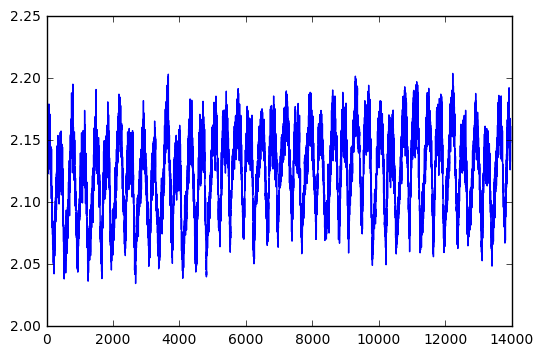

In [3]:
plt.plot(Pressure)
plt.show()

In [4]:
def build_XI(input_list):
    """
    To make inputs x in multi-output setting

    input_list : list of numpy array
    inputs of each outputs
    """
    num_outputs = len(input_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )

    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}

    return X,I

In [5]:
def narx_form(reg_size, input_list, output_list):
    """
    all inputs and outputs have same length
    """
    train_len = len(input_list[0])-reg_size
#     X = np.zeros((train_len, len(input_list) * reg_size + 1))
    X = np.zeros((train_len, len(input_list) * reg_size))
    Y = np.zeros((len(input_list), train_len))

    for i in range(len(input_list)):
        for j in range(train_len):
            X[j, reg_size*i:reg_size*(i+1)] = input_list[i][j:j+reg_size].ravel()
#             X[j, -1] = j
        Y[i] = output_list[i][reg_size:]
    
    return X, Y
    

In [6]:
def calculate_n(X, x_t):
    """
    calculate number density by gaussian smoother

    X : numpy array
    All observations

    x_t : float
    Test point 

    """
    X_t = x_t * np.ones(len(X))[:,None]
    #h = 2* min(self.kern[0].ICM0.Mat32.lengthscale[0], self.kern[0].ICM1.Mat52.lengthscale[0])
    h = mul.kern.Mat52.lengthscale[0]
    k = ((X - X_t)**2) / (2*h**2)
    print(k)
    ke = np.exp(-k)
    n = np.sum(ke)

    return n

In [7]:
def Mahalanobis_distance(model, x_test, y_obs):
    """
    calculate Mahalanobis_distance

    kern : GPy kernel object
    kernel of model

    x_test : numpy array
    test points

    y_pred : numpy array
    prediction mean of test points
    """
    X, I = build_XI([x_test,x_test])
    mean, var = model.predict(X, full_cov=True, Y_metadata=I)
    l = len(x_test)
    MD2 = np.dot(np.dot(np.transpose(y_obs - mean[l:2*l]), np.linalg.inv(var[l:2*l, l:2*l])), y_obs - mean[l:2*l])

    return MD2

In [8]:
F = Flow[:6000]/1000; P = Pressure[:6000]

In [9]:
r = 5
X,Y = narx_form(r, [F,P],[F,P])

In [12]:
# k1 = GPy.kern.RBF(input_dim=61)
# k2 = GPy.kern.Matern52(input_dim=61) 
# lcm = GPy.util.multioutput.LCM(input_dim=61, num_outputs=2, kernels_list=[k1,k2])
# mul = GPy.models.GPCoregionalizedRegression([X[:5000], X[:5000]], [Y[0][:,None][:5000], Y[1][:,None][:5000]], kernel=lcm)
# mul.optimize()


# k1 = GPy.kern.RBF(input_dim=2 * r)
# k2 = GPy.kern.Matern52(input_dim=2 * r) 
# lcm = GPy.util.multioutput.LCM(input_dim=2 * r, num_outputs=2, kernels_list=[k1])
# mul = GPy.models.GPCoregionalizedRegression([X, X], [Y[0][:,None], Y[1][:,None]], kernel=lcm)
# mul.optimize()

# kern = mul.kern.copy()
# n1 = mul.likelihood.Gaussian_noise_0.variance[0].copy()
# n2 = mul.likelihood.Gaussian_noise_1.variance[0].copy()
        
# f = open('d:/Narx_rbf', 'wb')
# pickle.dump([kern, n1, n2], f)
# f.close()

f = open('d:/Narx_rbf','rb')
gp = pickle.load(f)
f.close()

In [38]:
k1 = GPy.kern.RBF(input_dim=1)
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=[k1])
time = np.arange(len(F))[:,None]
model = GPy.models.GPCoregionalizedRegression([time[:500], time[:500]], [F[:500][:,None], P[:500][:,None]], kernel=lcm)
model.optimize()

In [49]:
Xt, It = build_XI([time[:500],time[:500]])
m, v = model.predict(Xt, Y_metadata=It, kern=model.kern,likelihood=model.likelihood)

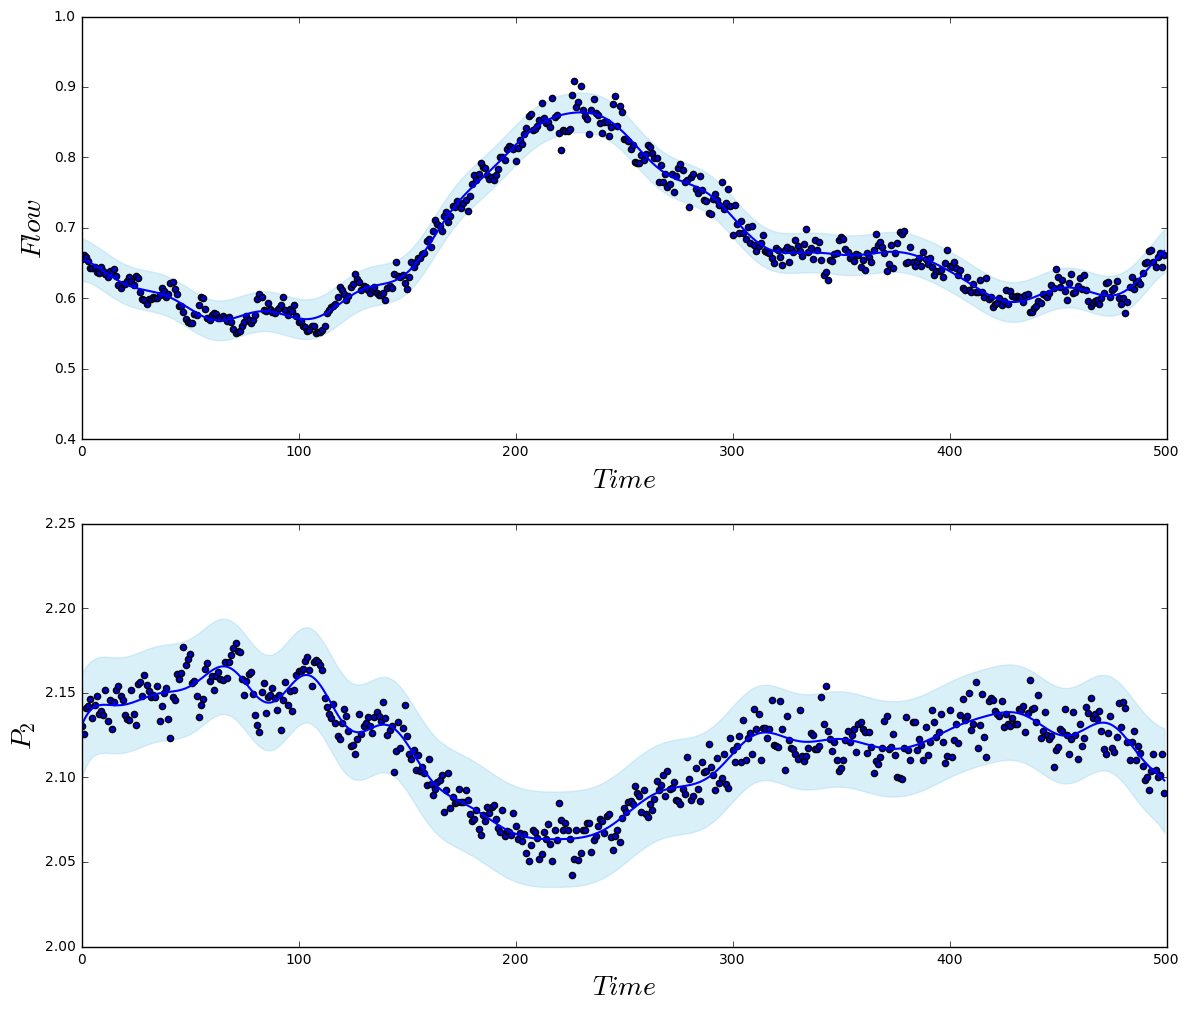

In [53]:
c1 = (np.array(m[:500]+1.96*np.sqrt(v[:500])))[:,0]
c2 = (np.array(m[:500]-1.96*np.sqrt(v[:500])))[:,0]
c3 = (np.array(m[500:]+1.96*np.sqrt(v[:500])))[:,0]
c4 = (np.array(m[500:]-1.96*np.sqrt(v[:500])))[:,0]

fig = pb.figure(figsize=(14,12))

ax1 = fig.add_subplot(211)
ax1.set_xlim([0,500])
ax1.set_ylim([0.4,1.0])
plt.plot(m[:500],color='blue',label="mean",lw=1.5)
plt.xlabel(r'$Time$',fontsize=20)
plt.ylabel(r'$Flow$',fontsize = 20)
plt.scatter(time[0:500],F[0:500],s = 20,color='mediumblue', zorder=2,edgecolors='black')
# plt.plot(m[:500]+1.96*np.sqrt(v[:500]),color='red',label="Extreme boundary",lw=1.5)
# plt.plot(m[:500]-1.96*np.sqrt(v[:500]),color='red',label="Extreme boundary",lw=1.5)
plt.fill_between(t[0:500], c1, c2, color='skyblue', alpha=0.3,label="Extreme quantile")

ax2 = fig.add_subplot(212)
ax2.set_xlim([0,500])
plt.xlabel(r'$Time$',fontsize=20)
plt.ylabel(r'$P_{2}$',fontsize = 20)
plt.plot(m[500:],color='blue',label="mean",lw=1.5)
plt.scatter(time[0:500],P[:500],s = 20,color='mediumblue', zorder=2,edgecolors='black')
# plt.plot(m[500:]+1.96*np.sqrt(v[500:]),color='red',label="Extreme boundary",lw=1.5)
# plt.plot(m[500:]-1.96*np.sqrt(v[500:]),color='red',label="Extreme boundary",lw=1.5)
plt.fill_between(t[0:500], c3, c4, color='skyblue', alpha=0.3,label="Extreme quantile")

plt.show()

In [42]:
len(time)

6000

In [15]:
mul = GPy.models.GPCoregionalizedRegression([X, X], [Y[0][:,None], Y[1][:,None]], kernel=gp[0])
mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp[1])
mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp[2])
print(1)

1


In [16]:
Y1 = Y[0][:,None]
Y2 = Y[1][:,None]
kern = mul.kern.copy()

In [29]:
c1 = (np.array(mu[:len(X)]+1.96*np.sqrt(var[:len(X)])))[:,0]
c2 = (np.array(mu[:len(X)]-1.96*np.sqrt(var[:len(X)])))[:,0]
c3 = (np.array(mu[len(X):]+1.96*np.sqrt(var[:len(X)])))[:,0]
c4 = (np.array(mu[len(X):]-1.96*np.sqrt(var[:len(X)])))[:,0]

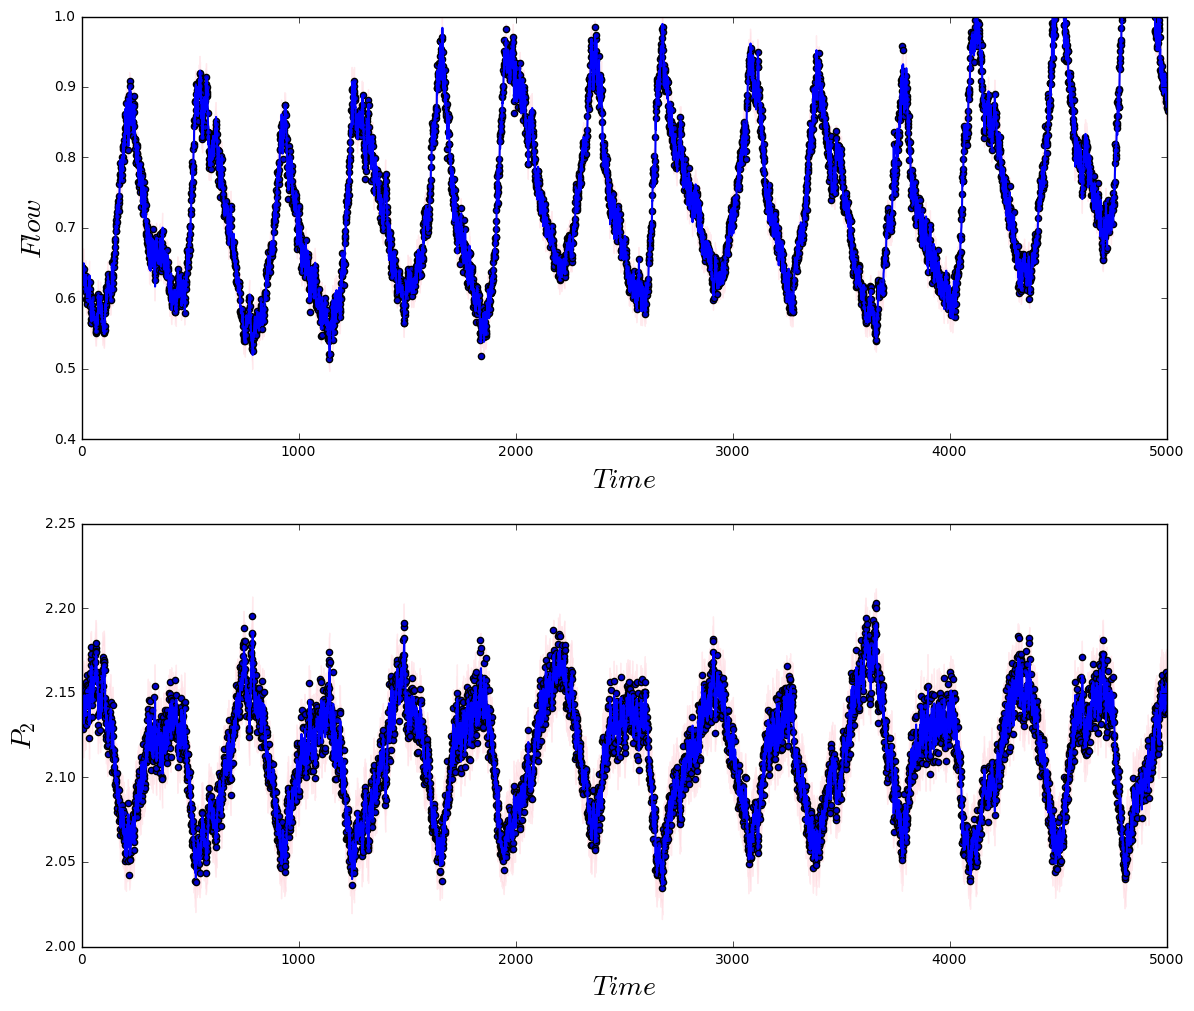

In [34]:
fig = pb.figure(figsize=(14,12))

ax1 = fig.add_subplot(211)
ax1.set_xlim([0,5000])
ax1.set_ylim([0.4,1.0])
plt.plot(mu[:len(X)],color='blue',label="mean",lw=1.5)
plt.xlabel(r'$Time$',fontsize=20)
plt.ylabel(r'$Flow$',fontsize = 20)
plt.scatter(t,Y[0],s = 20,color='mediumblue', zorder=2,edgecolors='black')
# plt.plot(mu[:len(X)]+1.96*np.sqrt(var[:len(X)]),color='red',label="Extreme boundary",lw=1.5)
# plt.plot(mu[:len(X)]-1.96*np.sqrt(var[:len(X)]),color='red',label="Extreme boundary",lw=1.5)
plt.fill_between(t, c1, c2, color='pink', alpha=0.3,label="Extreme quantile")

t = np.arange(len(Y[1]))
ax2 = fig.add_subplot(212)
ax2.set_xlim([0,5000])
plt.xlabel(r'$Time$',fontsize=20)
plt.ylabel(r'$P_{2}$',fontsize = 20)
plt.plot(mu[len(X):],color='blue',label="mean",lw=1.5)
plt.scatter(t,Y[1],s = 20,color='mediumblue', zorder=2,edgecolors='black')
# plt.plot(mu[len(X):]+1.96*np.sqrt(var[len(X):]),color='red',label="Extreme boundary",lw=1.5)
# plt.plot(mu[len(X):]-1.96*np.sqrt(var[len(X):]),color='red',label="Extreme boundary",lw=1.5)
plt.fill_between(t, c3, c4, color='pink', alpha=0.3,label="Extreme quantile")

plt.show()

In [17]:
start = 0
window = 150
end = 500
trend_w = 15

it = list(range(start, start + window)) # 첫번째 timeseries의 range
kt = it.copy()                          # 두번째 timeseries의 range
alarm_p = []
alarm_t = []

for i in range(start + window, end): 
    m = GPy.models.GPCoregionalizedRegression([X[it], X[kt]], [Y1[it], Y2[kt]], kernel = kern)
    m['.*Gaussian_noise_0.variance'].constrain_fixed(n1)
    m['.*Gaussian_noise_1.variance'].constrain_fixed(n2)
    # m.plot(plot_limits=[0,110],fixed_inputs=[(1,1)],which_data_rows=slice(len(self.x[it]),len(self.x[it])+len(self.x[kt])))
    # Point-wise anomaly detection
#     n = calculate_n(self.x[kt], self.x[i])
#     zp = self.z_score(n)
    zp = 3.5

    if i == start + window:                          # 초기 모델의 extreme quantile과 mean
        jt = kt + list([i])                       
        Xt,It = build_XI([X[jt], X[jt]])
        mu,var = m.predict(Xt,Y_metadata=It,kern=m.kern,likelihood=m.likelihood)
        mean = mu[int(len(mu)/2):len(mu)]
        variance = var[int(len(mu)/2):len(mu)]

        con_u = mean + np.sqrt(variance)*zp
        con_l = mean - np.sqrt(variance)*zp

        chi_sq = np.ones(window)[:,None]
    else:                                       # Test point의 그 순간의 extream boundary와 mean
        Xt,It = build_XI([np.reshape(X[i],(1,2*r)), np.reshape(X[i],(1,2*r))])
        mu,var = m.predict(Xt,Y_metadata=It,kern=m.kern,likelihood=m.likelihood)

        con_u = np.append(con_u, mu[1] + np.sqrt(var[1])*zp)
        con_l = np.append(con_l, mu[1] - np.sqrt(var[1])*zp)
        mean = np.append(mean, mu[1])

    if Y2[i] > con_u[i] or Y2[i] < con_l[i]: # alarm이 울리면 첫번째 time series는 update하고 두번째는 그대로
        alarm_p.append(i)
        it = it + list([i])
    else:
        it.pop(0)                                   # Window shifting
        it = it + list([i])
        kt.pop(0)
        kt = kt + list([i])

        if len(alarm_p) > 0:
            if alarm_p[len(alarm_p)-1] in kt:          # 이상이라고 판단된 x가 하나도 안들어있으면 첫번째 timeseries 다시 초기화
                pass
            else:
                it = kt.copy()

    # Trend anomaly detection                

    m2 = GPy.models.GPCoregionalizedRegression([X[it], X[kt[0:len(kt)-trend_w]]],[Y1[it],Y2[kt[0:len(kt)-trend_w]]],kernel = kern)
    m2['.*Gaussian_noise_0.variance'].constrain_fixed(n1)
    m2['.*Gaussian_noise_1.variance'].constrain_fixed(n2)

    ct = kt[len(kt)-trend_w:len(kt)]
    md2 = Mahalanobis_distance(m2, X[ct], Y2[ct])
    cs = chisqprob(md2, len(ct))[0][0]
    chi_sq = np.append(chi_sq,cs)



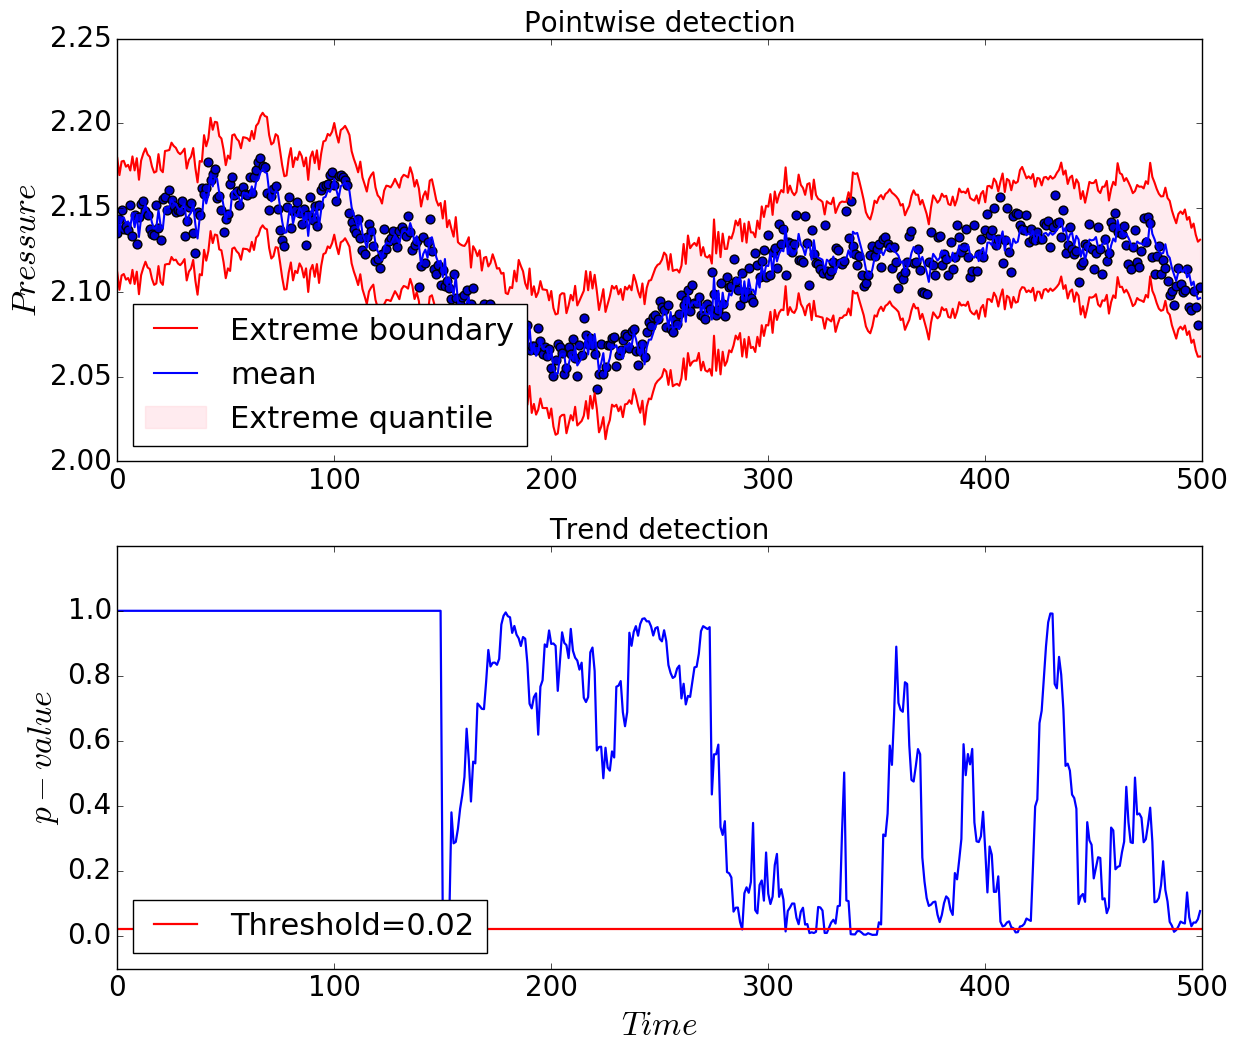

In [18]:
fig = pb.figure(figsize=(14,12))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

x = np.arange(start,end)
#Output 1
ax1 = fig.add_subplot(211)
ax1.set_xlim([start,end])
ax1.set_title('Pointwise detection',fontsize=20)
ax1.set_ylabel(r'$Pressure$',fontsize = 24)
ax1.tick_params(labelsize=20)

ax1.scatter(x, Y2[start:end], s = 40, color='mediumblue', zorder=2, edgecolors='black') 
ax1.scatter(x[alarm_p], Y2[alarm_p],s = 40, color='crimson', zorder=3, edgecolors='black')
ax1.plot(x, con_u, color='red', label="Extreme boundary",lw=1.5)
ax1.plot(x, con_l, color='red', lw=1.5)
ax1.fill_between(x, con_u, con_l, color='pink', alpha=0.3, label="Extreme quantile")
ax1.plot(x[start:end], mean, color='blue', label="mean", lw=1.5)
ax1.legend(fontsize=22, loc=3)


#Output 2
ax2 = fig.add_subplot(212)
ax2.set_xlim([start,end])
ax2.set_ylim([-0.1,1.2])
ax2.set_title('Trend detection',fontsize=20)
ax2.tick_params(labelsize=20)
ax2.set_xlabel(r'$Time$',fontsize=24)
ax2.set_ylabel(r'$p-value$',fontsize = 24)
ax2.plot(x[start:end], chi_sq, lw=1.6)
a = np.linspace(start,end,100)
th = 0.02 * np.ones(a.shape)
ax2.plot(a, th, color='red', label="Threshold=0.02", lw=1.6)
ax2.legend(fontsize=22, loc=3)

plt.show()

In [30]:
new_reg = np.zeros((2*r,1))
m1 = []
m2 = []
for i in range(30):
    if i == 0:
        regressor = X[-1]
        new_reg[0:r-1] = regressor[1:r][:,None]
        new_reg[r-1] = Y[0][-1]
        new_reg[r:2*r-1] = regressor[r+1:2*r][:,None]
        new_reg[2*r-1] = Y[1][-1]
    else:
        regressor = new_reg.copy()
        new_reg[0:r-1] = regressor[1:r]        
        new_reg[r:2*r-1] = regressor[r+1:2*r]

        new_reg[r-1] = Flow[200+i]/100
        new_reg[2*r-1] = Pressure[200+i]

#         xb, ib = build_XI([np.vstack([X,regressor.flatten()]),np.vstack([X,regressor.flatten()])])
        
        xb, ib = build_XI([np.reshape(regressor,(1,2*r)), np.reshape(regressor,(1,2*r))])
        m, var = mul.predict(xb, Y_metadata=ib, kern=mul.kern, likelihood=mul.likelihood)
        
#         new_reg[r-1] = m[0]
        
#         new_reg[2*r-1] = m[1]
        
        m1.append(m[0])
        m2.append(m[1])
        
        

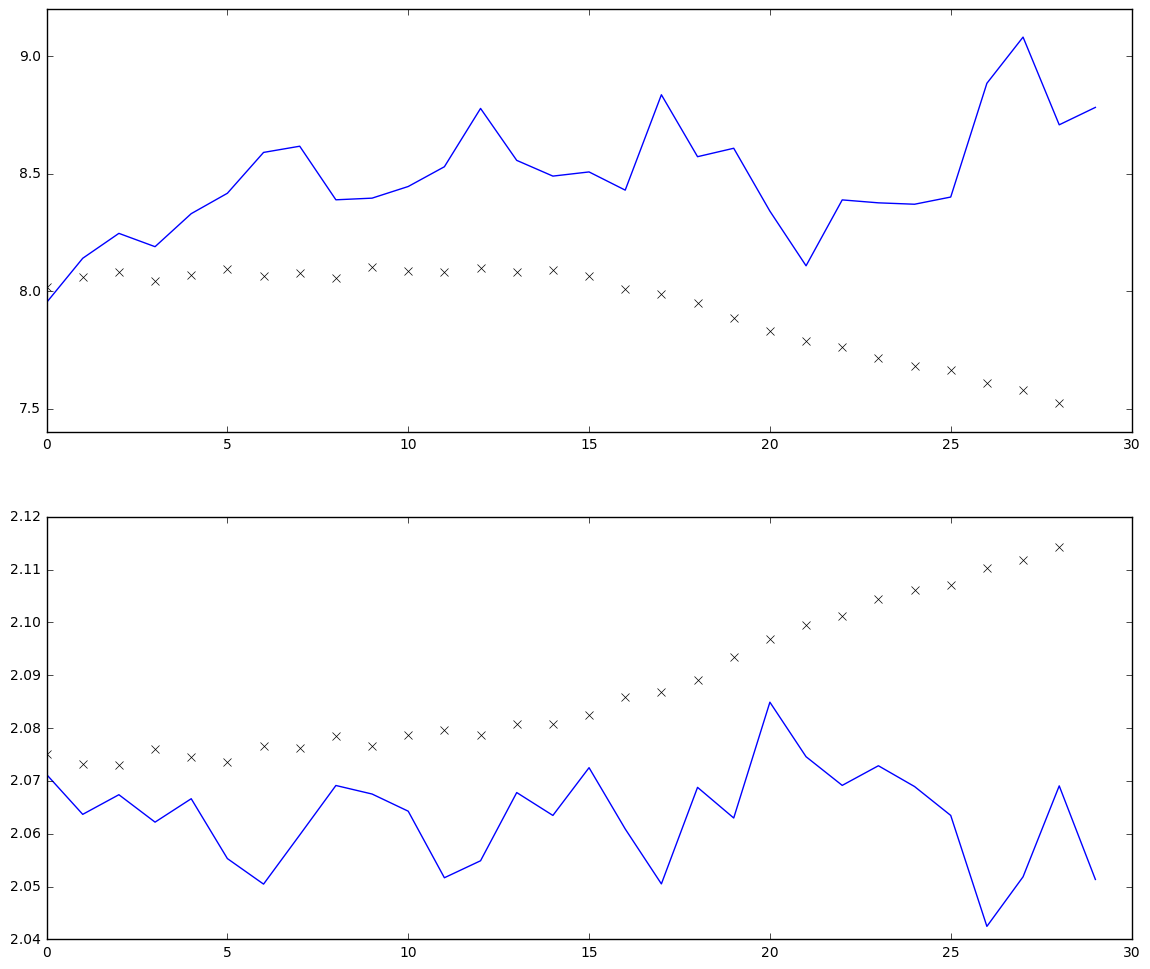

In [25]:
fig = pb.figure(figsize=(14,12))

ax1 = fig.add_subplot(211)
plt.plot(Flow[200:230]/100)
plt.plot(m1,'kx')

ax2 = fig.add_subplot(212)
plt.plot(Pressure[200:230])
plt.plot(m2,'kx')

plt.show()

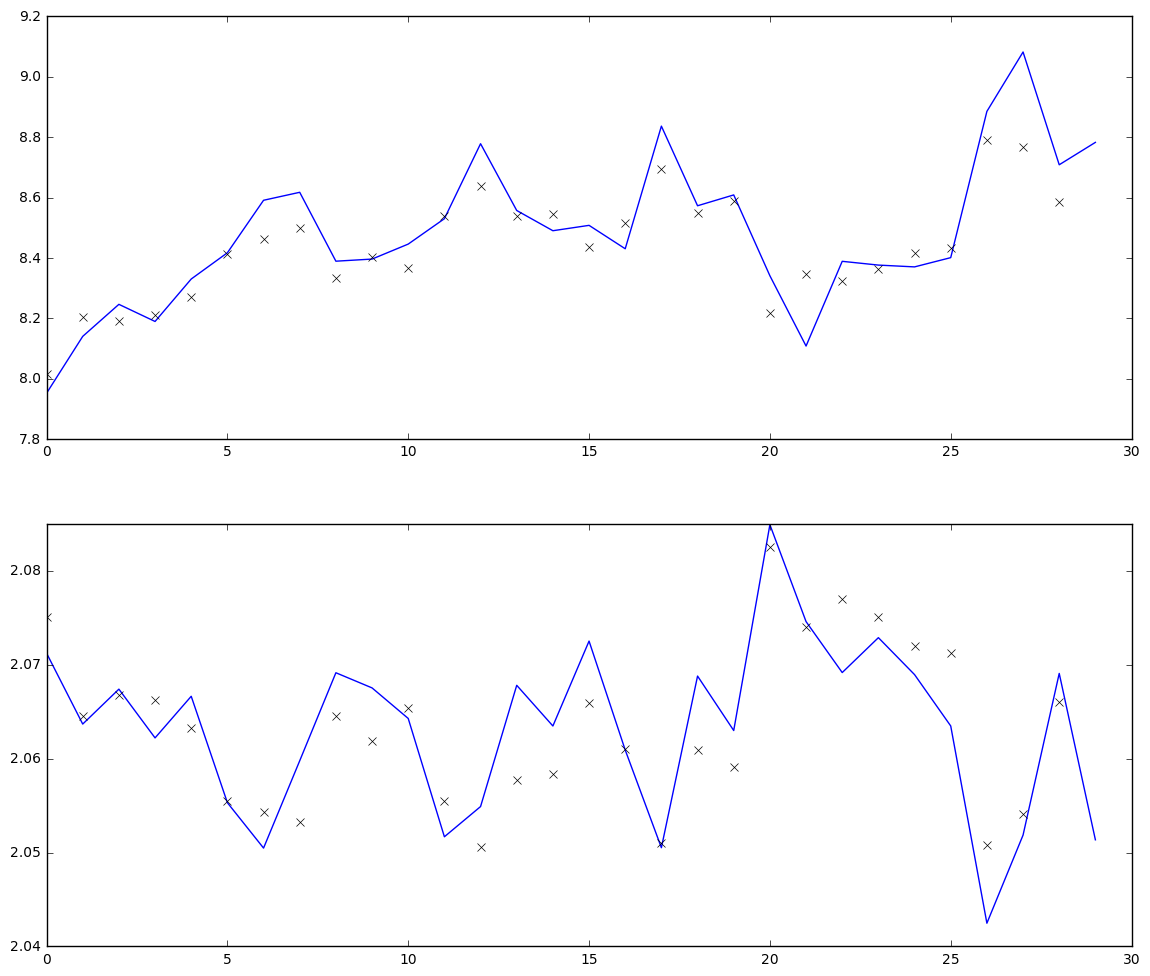

In [31]:
fig = pb.figure(figsize=(14,12))

ax1 = fig.add_subplot(211)
plt.plot(Flow[200:230]/100)
plt.plot(m1,'kx')

ax2 = fig.add_subplot(212)
plt.plot(Pressure[200:230])
plt.plot(m2,'kx')

plt.show()

In [29]:
m1

[]

In [71]:
def z_score(n):
    """
    calculate z score by GP-EVT (significance level : 0.98)        
    """
    alpha = (2 * np.log(n))**(-0.5)
    beta = (2 * np.log(n))**(0.5) - (np.log(np.log(n)) + np.log(2 * np.pi))/(2 * (2 * np.log(n))**0.5)
    zp = beta - alpha * np.log(-np.log(0.98))

    return zp

In [72]:
z_score(6000)

4.6270448333628575